In [43]:
import sympy as sp
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.primitives import Sampler
from qiskit.circuit.library import QFT, UnitaryGate
from helper import M_a
from math import gcd

In [44]:
def c_amodN(a,N):
    """
    Controlled multiplication by a mod N.
    """
    if gcd(a,N) != 1:
        raise ValueError("'a' must not have common factors with {N}")
    U = UnitaryGate(M_a(a, N))
    U.name = f"({a} mod {N})"
    c_U = U.control()
    return c_U

In [45]:
def phase_estimation(
        controlled_operation: QuantumCircuit,
        psi_prep: QuantumCircuit,
        precision: int
    ):
    """
    Carry out phase estimation on a simulator.
    Args:
        controlled_operation: The operation to perform phase estimation on,
                              controlled by one qubit.
        psi_prep: Circuit to prepare |ψ>
        precision: Number of counting qubits to use
    Returns:
        float: Best guess for phase of U|ψ>
    """
    control_register = QuantumRegister(precision)
    output_register = ClassicalRegister(precision)

    target_register = QuantumRegister(psi_prep.num_qubits)
    qc = QuantumCircuit(control_register, target_register, output_register)

    # Prepare |ψ>
    qc.compose(psi_prep,
               qubits=target_register,
               inplace=True)

    # Do phase estimation
    for index, qubit in enumerate(control_register):
        qc.h(qubit)
        for _ in range(2**index):
            qc.compose(
                controlled_operation,
                qubits=[qubit] + list(target_register),
                inplace=True,
            )

    qc.compose(
        QFT(precision, inverse=True),
        qubits=control_register,
        inplace=True
    )

    qc.measure(control_register, output_register)

    display(qc.draw(output="mpl"))
    
    measurement = Sampler().run(qc, shots=1).result().quasi_dists[0].popitem()[0]
    return measurement / 2**precision

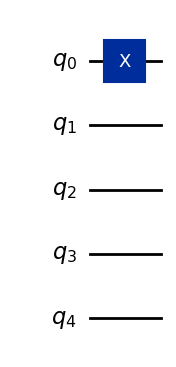

In [46]:
psi_prep = QuantumCircuit(5)
psi_prep.x(0)
display(psi_prep.draw(output="mpl"))


Attempt 1


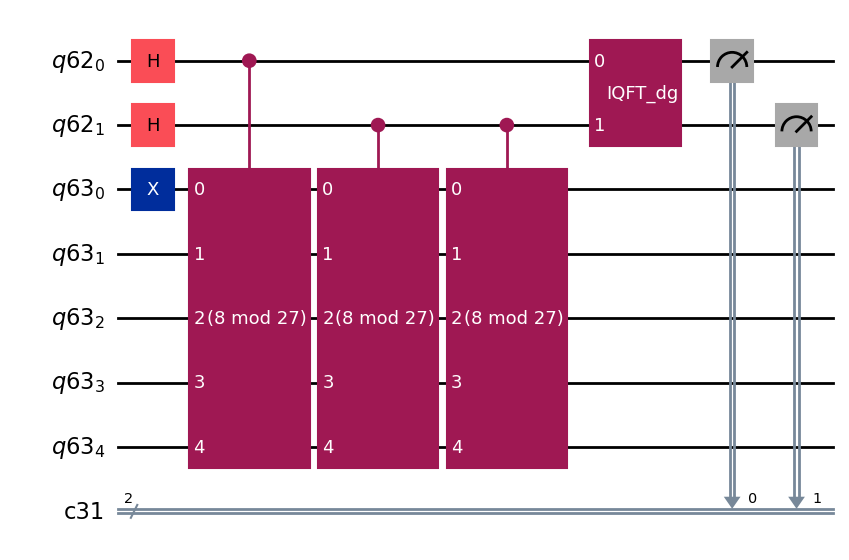

/tmp/ipykernel_7961/1484296275.py:47: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  measurement = Sampler().run(qc, shots=1).result().quasi_dists[0].popitem()[0]


Got phase: 0.5
Guess: 1

Attempt 2


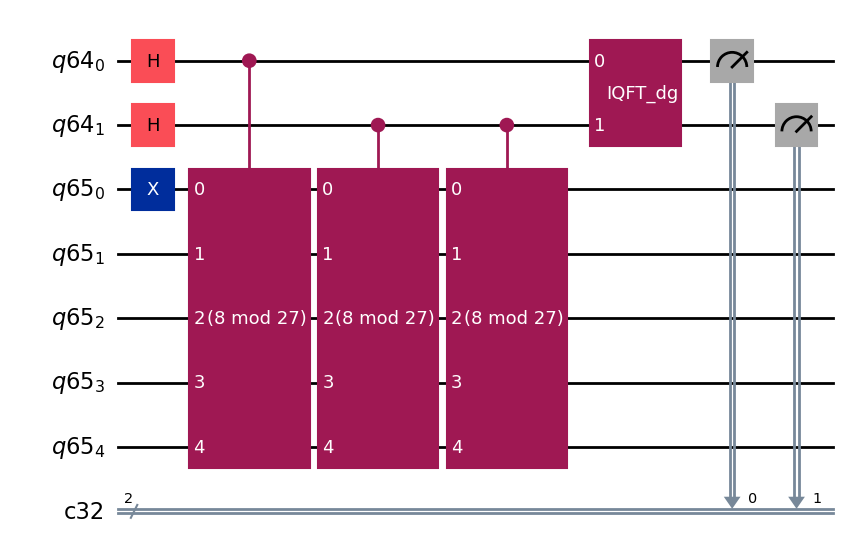

Got phase: 0.75
Guess: 9
Non-trivial factor found: 9


In [47]:
from fractions import Fraction
from math import gcd

N = 27
a=8

FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    ATTEMPT += 1
    print(f"\nAttempt {ATTEMPT}")

    phase = phase_estimation(
        c_amodN(a, N),
        psi_prep,
        precision=2
    )
    print(f"Got phase: {phase}")
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    if phase != 0:
        # Guess for a factor is gcd(x^{r/2} - 1 , 15)
        guess = gcd(a ** (r // 2) - 1, N)
        print(f"Guess: {guess}")
        if guess not in [1, N] and (N % guess) == 0:
            # Guess is a factor!
            print(f"Non-trivial factor found: {guess}")
            FACTOR_FOUND = True

In [48]:
# M_a(8, 21)